<p style ="text-align:center">
    <img src="http://epecora.com.br/DataFiles/PPGOLD_logo.png" width="300" alt="PPGOLD Data Science: INTRO"  />
</p>

# Aula 07-1 de Data Science

## Árvores de Decisão Avançado (Decision Trees Advanced)

* **Case de distribuição de e-commerce**
* Tempo estimado: **60** minutos

# Objetivos

Após completar esta aula, você será capaz de:

* Obter os dados do case
* Realizar um pré processamento nos dados
* Realizar uma classificação supervisionada através de `Árvores de Decisão`
* Usar o método de validação crusada (cross validation)
* Criar árvores através do critério `Gini`
* Criar árvores através do critério `Entropia`
* Medir o desempenho do modelo de classificação


# Bibliotecas

In [7]:
# check Python version
!python -V

import pandas as pd # download library to read data into dataframe
import numpy as np # import numpy library
import matplotlib.pyplot as plt # plots
import collections
import random # library for random number generation

import matplotlib.pyplot as plt
import seaborn as sns

# import decision trees scikit-learn libraries
%matplotlib inline
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix # Não usaremos essas métricas neste exemplo
import matplotlib.pyplot as plt

#!conda install python-graphviz --yes
import graphviz
from sklearn.tree import export_graphviz
import itertools

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split # Import train_test_split function

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

Python 3.9.7


# Obtendo Dados

In [8]:
file_path = "https://raw.githubusercontent.com/EduPek/PPGOLD7037/main/Data/Distribution_12k.csv"
starsData = pd.read_csv(file_path)

# Pré Processamento

In [9]:
# Obtendo o nome das colunas
column_names = starsData.columns.values

# Alterando a primeira posição da lista para 'stars'
column_names[0] = "stars"

# Passando o novo nome para  o dataframe
starsData.columns = column_names

starsData = starsData[starsData["stars"] <= 5]
starsData = starsData[starsData["stars"] >= 1]

starsData = starsData[starsData["FloorCD"] <= 4] 
starsData = starsData[starsData["FloorCD"] >= 0]

starsData = starsData[starsData["RoutDeliveryOrder"] <= 6]
starsData = starsData[starsData["RoutDeliveryOrder"] >= 1]

# É importante refazer o indice do dataFrame, após excluir linhas, pois pode gerar problema no SciKit Learn
starsData = starsData.reset_index(drop=True) 

# variáveis Dependentes e independentes the DataFrame
# split the DataFrame
# Só a coluna "stars"
dependentVariableStars = starsData["stars"].copy(deep=True) 

# Todas as outras colunas com excessão da "stars"
independetVariables = starsData.drop(columns=['stars']).copy(deep=True)

enc = OneHotEncoder(handle_unknown='ignore', sparse= False)

prod_encoded = pd.DataFrame (enc.fit_transform(independetVariables[['Product']])).astype(int)
prod_encoded.columns = enc.get_feature_names_out(['Product'])

origin_encoded = pd.DataFrame (enc.fit_transform(independetVariables[['Origin']])).astype(int)
origin_encoded.columns = enc.get_feature_names_out(['Origin'])

CD_encoded = pd.DataFrame (enc.fit_transform(independetVariables[['CD_name']])).astype(int)
CD_encoded.columns = enc.get_feature_names_out(['CD_name'])

Destination_encoded = pd.DataFrame (enc.fit_transform(independetVariables[['Dest']])).astype(int)
Destination_encoded.columns = enc.get_feature_names_out(['Dest'])

TruckType_encoded = pd.DataFrame (enc.fit_transform(independetVariables[['TruckType']])).astype(int)
TruckType_encoded.columns = enc.get_feature_names_out(['TruckType'])

TruckType2_encoded = pd.DataFrame (enc.fit_transform(independetVariables[['TruckType2']])).astype(int)
TruckType2_encoded.columns = enc.get_feature_names_out(['TruckType2'])

DriverCD_C_encoded = pd.DataFrame (enc.fit_transform(independetVariables[['DriverCD_C']])).astype(int)
DriverCD_C_encoded.columns = enc.get_feature_names_out(['DriverCD_C'])

independetVariablesEncoded = pd.concat([prod_encoded, origin_encoded, CD_encoded, Destination_encoded, TruckType_encoded, TruckType2_encoded, DriverCD_C_encoded, independetVariables["RoutDeliveryOrder"], independetVariables["FloorCD"]], axis=1)

dependentVariableStars = pd.DataFrame({'stars':dependentVariableStars})

bad_conditions = dependentVariableStars['stars'] <= 2
average_conditions = dependentVariableStars['stars'] == 3
good_conditions = dependentVariableStars['stars'] >= 4

dependentVariableStars[bad_conditions] = "bad"
dependentVariableStars[average_conditions] = "average"
dependentVariableStars[good_conditions] = "good"

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was re

# Árvores de Decisão

## Train Test Split

In [11]:
print('Shape das variáveis independentes',independetVariablesEncoded.shape)
print('Shape das variáveis dependetes',dependentVariableStars.shape)

Shape das variáveis independentes (12281, 65)
Shape das variáveis dependetes (12281, 1)


In [12]:
splited = train_test_split(independetVariablesEncoded, dependentVariableStars, test_size=0.3) # 70% training and 30% test
splited

[       Product_P1  Product_P10  Product_P11  Product_P12  Product_P13  \
 6863            0            0            0            0            0   
 3676            0            0            0            0            0   
 637             0            0            0            0            0   
 9120            0            0            0            0            0   
 11540           0            0            0            0            0   
 ...           ...          ...          ...          ...          ...   
 7253            0            0            0            0            0   
 2676            0            0            0            0            0   
 1832            1            0            0            0            0   
 1124            0            0            0            0            0   
 11113           0            1            0            0            0   
 
        Product_P14  Product_P15  Product_P2  Product_P3  Product_P4  ...  \
 6863             0            0 

In [13]:
independetVariablesEncodedTrain = splited[0]
print('Shape do dataframe com as variáveis independentes que serão usadas para treinar o modelo:\n',independetVariablesEncodedTrain.shape)


Shape do dataframe com as variáveis independentes que serão usadas para treinar o modelo:
 (8596, 65)


In [14]:
independetVariablesEncodedTest = splited[1]
print('Shape do dataframe com as variáveis independentes que serão usadas para testar o modelo:\n',independetVariablesEncodedTest.shape)


Shape do dataframe com as variáveis independentes que serão usadas para testar o modelo:
 (3685, 65)


In [15]:
dependentVariableStarsTrain =  splited[2]
print('Shape do dataframe com a variável dependentes que serão usadas para treinar o modelo:\n',dependentVariableStarsTrain.shape)


Shape do dataframe com a variável dependentes que serão usadas para treinar o modelo:
 (8596, 1)


In [16]:
dependentVariableStarsTest =  splited[3]
print('Shape do dataframe com a variável dependentes que serão usadas para testar o modelo:\n',dependentVariableStarsTest.shape)


Shape do dataframe com a variável dependentes que serão usadas para testar o modelo:
 (3685, 1)


## Árvore de Decisão: Critério Gini

In [17]:
delivery_tree = tree.DecisionTreeClassifier(criterion="gini", max_depth = 25)
#delivery_tree = tree.DecisionTreeClassifier(criterion="gini", max_depth = 25, min_samples_split = 2, min_samples_leaf = 1)

delivery_tree.fit(independetVariablesEncodedTrain, dependentVariableStarsTrain)

dependentVariableStarsPredicted = delivery_tree.predict(independetVariablesEncodedTest)

print("Accuracy:", accuracy_score(dependentVariableStarsTest, dependentVariableStarsPredicted))

Accuracy: 0.86078697421981


In [18]:
# nome das colunas
columnsList = independetVariablesEncodedTrain.columns
# importancias
ColumnsImportance = delivery_tree.feature_importances_

In [19]:
df_importance = pd.DataFrame({'variable':columnsList,'importance':ColumnsImportance})
df_importance.set_index(keys='variable',inplace=True)
df_importance.index.name = None
df_importance.sort_values(by='importance',inplace=True)
df_importanceTop15 = df_importance.tail(15)

Text(0, 0.5, 'Variables')

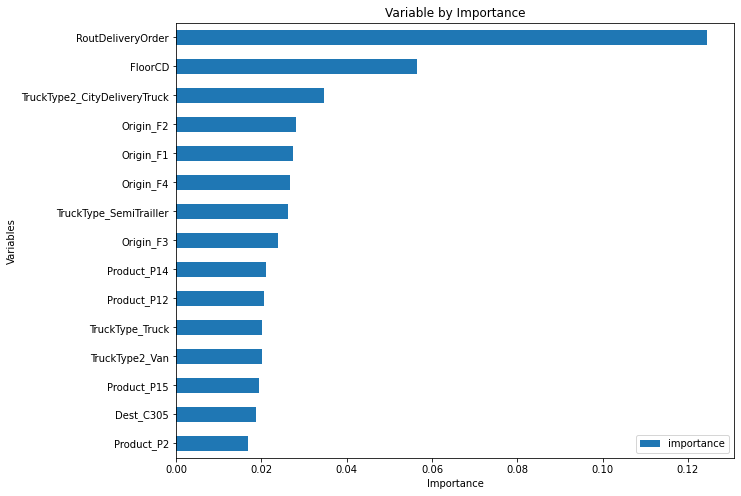

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
df_importanceTop15.plot(kind='barh',ax=ax)
ax.set_title('Variable by Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Variables')

Text(0, 0.5, 'Variables')

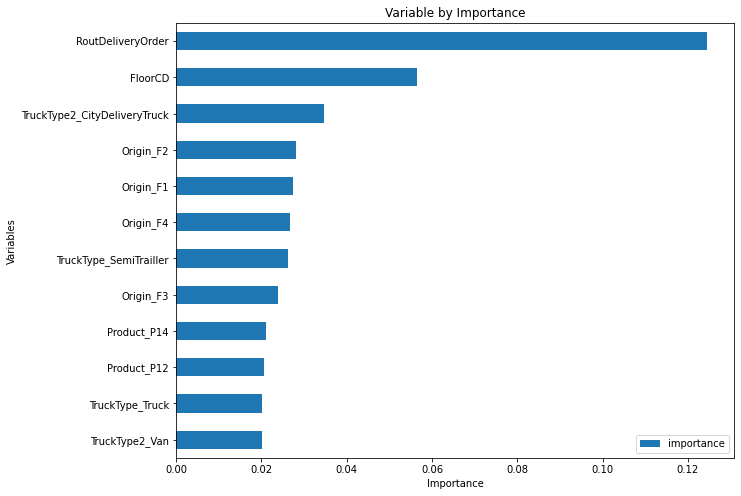

In [21]:
df_importance_bests = df_importance[df_importance['importance'] > 0.02]
fig, ax = plt.subplots(figsize=(10,8))
df_importance_bests.plot(kind='barh',ax=ax)
ax.set_title('Variable by Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Variables')

## Árvore de Decisão: Critério Entropia

* Para maiores detalhes da diferença entre o Gini e a Entropia ver [4]

In [22]:
delivery_tree_entropy = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 25)
delivery_tree_entropy.fit(independetVariablesEncodedTrain, dependentVariableStarsTrain)

dependentVariableStarsEntropyPredicted = delivery_tree_entropy.predict(independetVariablesEncodedTest)
print("Accuracy:", accuracy_score(dependentVariableStarsTest, dependentVariableStarsEntropyPredicted))

Accuracy: 0.842876526458616


Text(0, 0.5, 'Variables')

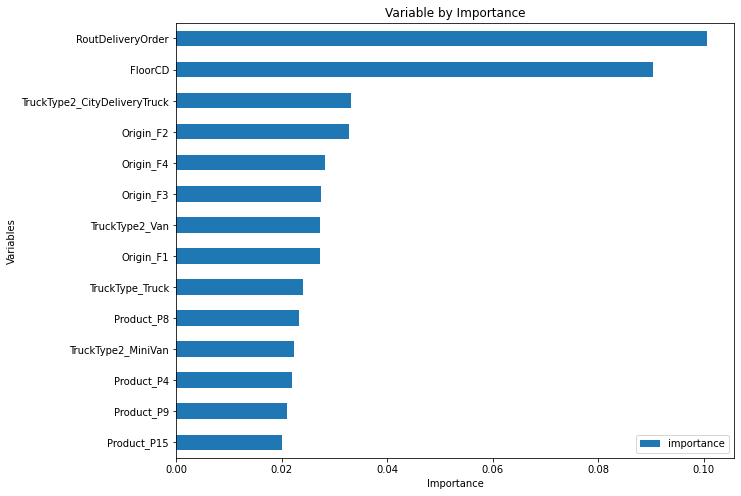

In [23]:
# nome das colunas
columnsListEntropy = independetVariablesEncodedTrain.columns
# importancias
ColumnsImportanceEntropy = delivery_tree_entropy.feature_importances_

df_importanceEntropy = pd.DataFrame({'variable':columnsListEntropy,'importance':ColumnsImportanceEntropy})
df_importanceEntropy.set_index(keys='variable',inplace=True)
df_importanceEntropy.index.name = None
df_importanceEntropy.sort_values(by='importance',inplace=True)
df_importanceEntropyTop15 = df_importanceEntropy.tail(15)

df_importance_entropy_bests = df_importanceEntropy[df_importanceEntropy['importance'] > 0.02]
fig, ax = plt.subplots(figsize=(10,8))
df_importance_entropy_bests.plot(kind='barh',ax=ax)
ax.set_title('Variable by Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Variables')

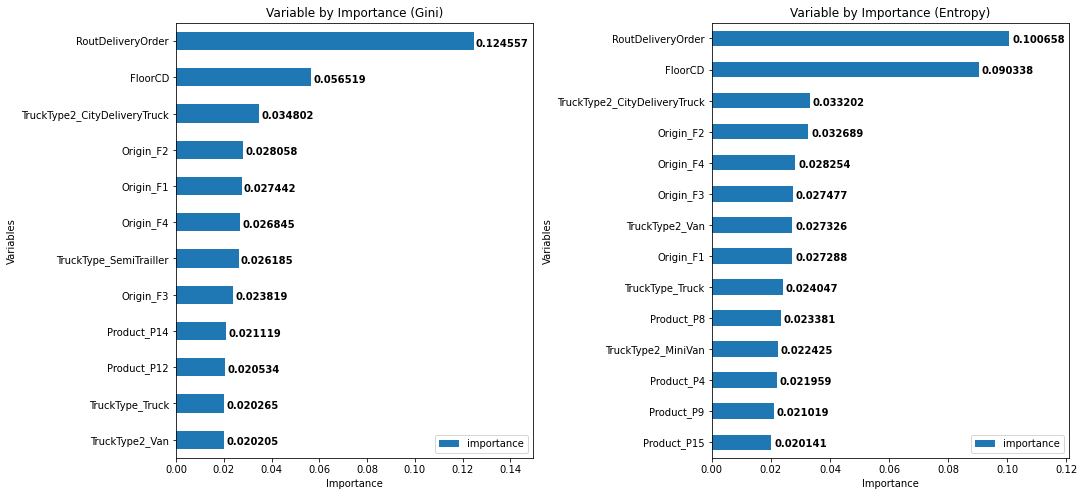

In [24]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

df_importance_bests.plot(kind='barh',ax=ax[0])
ax[0].set_title('Variable by Importance (Gini)')
ax[0].set_xlabel('Importance')
ax[0].set_ylabel('Variables')
ax[0].set_xlim([0, df_importance_bests['importance'].max() * 1.2])

df_importance_entropy_bests.plot(kind='barh',ax=ax[1])
ax[1].set_title('Variable by Importance (Entropy)')
ax[1].set_xlabel('Importance')
ax[1].set_ylabel('Variables')
ax[1].set_xlim([0, df_importance_entropy_bests['importance'].max() * 1.2])

plt.subplots_adjust(wspace=0.5)

for i, v in enumerate(df_importance_bests['importance']):
    tt = '%.6f' % v
    ax[0].text(v + 0.001, i - 0.15, str(tt), color='black', fontweight='bold')

for i, v in enumerate(df_importance_entropy_bests['importance']):
    tt = '%.6f' % v
    ax[1].text(v + 0.001, i - 0.15, str(tt), color='black', fontweight='bold')

## Medindo Desempenho: Matriz de confusão

* A nossa matriz que contêm 3 classes pode ser interpretada da seguinte maneira:

    * A diagonal principal contém o número de amostras que foram classificadas corretamente.
    * A célula (`Average`,`Bad`) que equivale a primeira linha segunda coluna, contém o número de amostras que pertencem a classe `Average` mas foram classificadas com pertencentes a classe `Bad`
    * As linhas representam as classes reais, enquanto as colunas representam as classes preditas.

Text(0.5, 24.0, 'Predicted label')

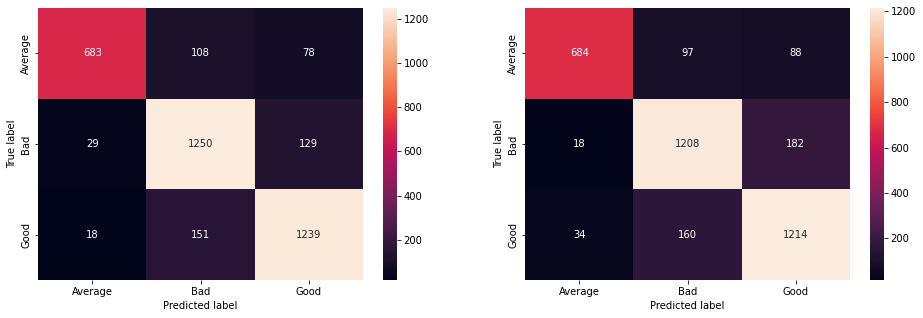

In [25]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

confusion_matrix_gini = confusion_matrix(dependentVariableStarsTest, dependentVariableStarsPredicted)
sns.heatmap(confusion_matrix_gini, annot=True, xticklabels = ["Average","Bad","Good"], yticklabels = ["Average","Bad","Good"],ax=ax[0],fmt='.4g')
ax[0].set_ylabel('True label')
ax[0].set_xlabel('Predicted label')

confusion_matrix_entropy = confusion_matrix(dependentVariableStarsTest, dependentVariableStarsEntropyPredicted)
sns.heatmap(confusion_matrix_entropy, annot=True, xticklabels = ["Average","Bad","Good"], yticklabels = ["Average","Bad","Good"],ax=ax[1],fmt='.4g')
ax[1].set_ylabel('True label')
ax[1].set_xlabel('Predicted label')

## Grid Search - Melhores Parâmetros

In [26]:
X = independetVariablesEncodedTrain
Y = dependentVariableStarsTrain

tree_param = {'criterion':['gini','entropy'],'max_depth':[3,10,15,20,30,60,65,70,80,100,200,500]}
grid = GridSearchCV(tree.DecisionTreeClassifier(random_state= 100), tree_param, cv=5)
grid.fit(X, Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 10, 15, 20, 30, 60, 65, 70, 80, 100,
                                       200, 500]})

In [27]:
print('The parameters combination that would give best accuracy are: ')
print(grid.best_params_)
print('The best accuracy achieved: ', grid.best_score_)

print(grid.best_params_['criterion'])

The parameters combination that would give best accuracy are: 
{'criterion': 'gini', 'max_depth': 60}
The best accuracy achieved:  0.9289198695834516
gini


In [28]:
delivery_tree_best = tree.DecisionTreeClassifier(criterion = grid.best_params_["criterion"], max_depth = grid.best_params_["max_depth"])
delivery_tree_best.fit(independetVariablesEncodedTrain, dependentVariableStarsTrain)

dependentVariableStarsGridPredicted = delivery_tree_best.predict(independetVariablesEncodedTest)
print("Accuracy:", accuracy_score(dependentVariableStarsTest, dependentVariableStarsGridPredicted))

Accuracy: 0.9742198100407056


Text(0.5, 24.0, 'Predicted label')

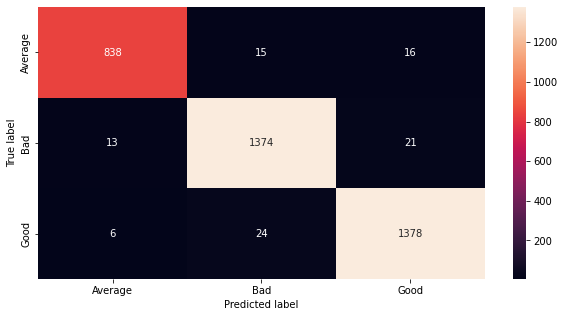

In [29]:
confusion_matrix_grid = confusion_matrix(dependentVariableStarsTest, dependentVariableStarsGridPredicted)
fig , ax = plt.subplots(1,1,figsize=(10,5))
sns.heatmap(confusion_matrix_grid, annot=True, xticklabels = ["Average","Bad","Good"], yticklabels = ["Average","Bad","Good"],fmt='.4g',ax=ax)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

## Referências

[1] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[2] https://scikit-learn.org/stable/modules/cross_validation.html

[3] https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

[4] https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf

[5] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


## Autores

<a href="https://www.linkedin.com/in/eduardopecora/" target="_blank">Eduardo Pecora</a>

<a href="https://www.linkedin.com/in/hesauhugocavalcanti/" target="_blank">Hesau Hugo</a>

## Log de modificações

| Data | Versão | Modificado por | Descrição |
| ----------------- | ------- | ---------- | ---------------------------------- |
| 03-10-2021       | 1.0     | Eduardo Pecora    | Criação               |
| 17-04-2023       | 1.1     | Hesau Hugo        | Reestruturação        |
<hr>

